## Spam Message Classification

#### 데이터 다운로드 : https://suanlab.com/datasets/spam.csv

In [1]:
!wget http://suanlab.com/datasets/spam.csv

--2022-09-20 19:31:05--  http://suanlab.com/datasets/spam.csv
Resolving suanlab.com (suanlab.com)... 52.219.60.137
Connecting to suanlab.com (suanlab.com)|52.219.60.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K   786KB/s    in 0.6s    

2022-09-20 19:31:06 (786 KB/s) - ‘spam.csv’ saved [503663/503663]



In [2]:
import pandas as pd

df = pd.read_csv('spam.csv', delimiter=',', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df=df.iloc[:,:2] # 컬럼 제거
df.columns = ['target','message']
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   target   5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<AxesSubplot:>

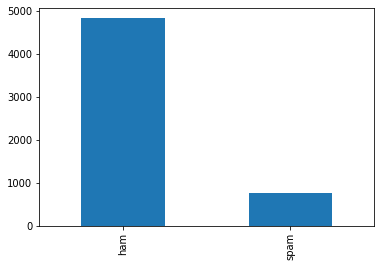

In [4]:
x = df.message
y = df.target

y.value_counts().plot(kind='bar')
# 분류 문제에서 하나의 카테고리 데이터의 양이
# 다른 카테고리의 데이터 양 보다 많이 적을 수 있음
# 이 경우 *Oversampling* 등의 기법 적용
# 일반적으로 스팸 메세지가 일반 메세지보다 적기 때문에 다음과 같은 결과

In [5]:
print('최대 길이 : {}'.format(max(len(i) for i in x)))
print('평균 길이 : {}'.format((sum(map(len, x))/len(x))))

최대 길이 : 910
평균 길이 : 80.11880832735105


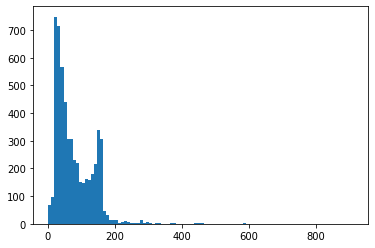

In [6]:
import matplotlib.pyplot as plt

plt.hist([len(i) for i in x], bins=100)
plt.show();

In [7]:
df.to_numpy()

array([['ham',
        'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
       ['ham', 'Ok lar... Joking wif u oni...'],
       ['spam',
        "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
       ...,
       ['ham',
        'Pity, * was in mood for that. So...any other suggestions?'],
       ['ham',
        "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free"],
       ['ham', 'Rofl. Its true to its name']], dtype=object)

In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('spacy', 'en_core_web_sm')
data_iter= iter(df.to_numpy())

# Tokenizing 함수
def yield_tokens(data_iter):
    for _, text in data_iter:
    # target을 사용 안함을 _로 표현
    # 두 번째 컬럼의 .text
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(data_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [9]:
vocab('Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.'.split())

[308, 525, 13, 29, 7, 1190, 1054, 2, 356, 2225, 2770, 928, 2612, 2671, 666, 0]

In [10]:
text_transform = lambda x: vocab(tokenizer(x))
label_transform = lambda x: 1 if x=='ham' else 0

In [11]:
text_transform('Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.')

[308,
 525,
 13,
 29,
 7,
 1190,
 1054,
 2,
 356,
 2225,
 2770,
 928,
 2612,
 2671,
 666,
 2669,
 1]

In [12]:
label_transform('ham'), label_transform('spam')

(1, 0)

- 데이터 배치의 텍스트 항목은 List에 보관된(Pack) 다음 nn.EmbeddingBag의 입력을 위한 하나의 Tensor로 결합 (Concatenate)
- Offset : Text Tensor에서 개별 시퀀스 시작 인덱스를 표현하기 위한 구분자(delimiter) Tensor
- Label : 개별 텍스트 항목의 레이블을 저장하는 Tensor

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    # 초기화 // 실제 필요한 정보
    
    for (_label, _text) in batch: # _ : 해당 과정에서만 사용(추후 사용 ×)
        label_list.append(label_transform(_label))
        
        processed_text = torch.tensor(text_transform(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
        # 실제 처리된 텍스트에 대한 사이즈(길이) 저장
        
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

- torch.utils.data.DataLoader는 getitem()과 len() 프로토콜을 구현한 맵 형태(Map-style)의 데이터셋으로 동작하며 맵(Map)처럼 Index/Key로 데이터 샘플 로드
- Shuffle 인자를 False로 설정하면 순회 가능한(iterable) 데이터셋처럼 동작(일반적으로는 Shuffling 사용)
- collate_fn 함수는 모델로 보내기 전 DataLoader로부터 생성된 샘플 배치로 동작
- collate_fn의 입력은 DataLoader에 배치 크기(Batch Size)가 있는 배치
- collate_fn은 미리 선언된 데이터 처리 파이프라인에 따라 처리

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

Batch_Size = 100

data_iter = iter(df.to_numpy())
dataset = to_map_style_dataset(data_iter)

num_train = int(len(dataset) * 0.85)
train_dataset, test_dataset = random_split(dataset,
                                           [num_train, len(dataset)-num_train])

num_train= int(len(train_dataset) *0.9)
train_dataset, valid_dataset = random_split(train_dataset,
                                           [num_train, len(train_dataset)-num_train])

print('Train Dataset: ', len(train_dataset))
print('Valid Dataset: ', len(valid_dataset))
print('Test Dataset: ', len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=Batch_Size,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=Batch_Size,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=Batch_Size,
                             shuffle=True, collate_fn=collate_batch)

Train Dataset:  4262
Valid Dataset:  474
Test Dataset:  836


### RNN 모델 정의 및 생성
- 임베딩을 위한 nn.EmbeddingBag(Padding 지정 없이(고정된 길이 없이) Offset에 지정된 텍스트의 길이 자체를 고려하는 방법) 레이어와 분류(Classification) 목적을 위한 선형 레이어 nn.Linear로 구성
- 기본 모드가 평균(mean)인 nn.EmbeddingBag은 임베딩들의 가방(Bag)의 평균을 계산
- 텍스트 항목들은 각기 그 길이가 다를 수 있지만 nn.EmbeddingBag 모듈은 텍스트의 길이를 Offset으로 저장하고 있으므로 Padding 불필요(Offset을 통해 정확하게 필요한 길이만 사용)
- nn.EmbeddingBag은 임베딩의 평균을 즉시 계산하기 때문에 Tensor들의 시퀀스를 처리할 때 성능 및 메모리 효율성 측면에서의 장점

In [15]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(RNNModel, self).__init__()
        self.embed = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.rnn = nn.RNN(embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_class)
        
    def forward(self, input, offsets):
        output = self.embed(input, offsets)
        output, hidden = self.rnn(output)
        output = self.fc(output)
        return output

In [16]:
model = RNNModel(vocab_size=len(vocab),
                 embed_dim = 300,
                 hidden_dim = 100,
                 num_class = 2)
model.to(device)

RNNModel(
  (embed): EmbeddingBag(11583, 300, mode=mean)
  (rnn): RNN(300, 100)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

### 모델 학습 및 평가

In [17]:
def train(dataloader):
    model.train()
    total_acc, total_count=0,0
    
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label=model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
    return total_acc / total_count

def evaluate(dataloader):
    model.eval()
    total_acc, total_count=0,0
    
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label=model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
        
    return total_acc / total_count

In [18]:
import time

epochs = 50
lr = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_acc = None

for epoch in range(1, epochs+1):
    epoch_start_time= time.time()
    train_acc = train(train_dataloader)
    valid_acc = evaluate(valid_dataloader)
    
    if total_acc is not None and total_acc > valid_acc:
        scheduler.step()
    else:
        total_acc = valid_acc
    
    print('Epoch: {:2d}'.format(epoch),
          '| Elapsed Time:{:5.2f}s'.format(time.time() - epoch_start_time),
          '| Train Accuracy: {:.4f}'.format(train_acc),
          '| Valid Accuracy: {:.4f}'.format(valid_acc))


Epoch:  1 | Elapsed Time: 1.87s | Train Accuracy: 0.8885 | Valid Accuracy: 0.8924
Epoch:  2 | Elapsed Time: 0.51s | Train Accuracy: 0.9303 | Valid Accuracy: 0.9072
Epoch:  3 | Elapsed Time: 0.63s | Train Accuracy: 0.9376 | Valid Accuracy: 0.9156
Epoch:  4 | Elapsed Time: 0.72s | Train Accuracy: 0.9472 | Valid Accuracy: 0.9283
Epoch:  5 | Elapsed Time: 0.52s | Train Accuracy: 0.9545 | Valid Accuracy: 0.9093
Epoch:  6 | Elapsed Time: 0.49s | Train Accuracy: 0.9751 | Valid Accuracy: 0.9262
Epoch:  7 | Elapsed Time: 0.58s | Train Accuracy: 0.9758 | Valid Accuracy: 0.9219
Epoch:  8 | Elapsed Time: 0.53s | Train Accuracy: 0.9758 | Valid Accuracy: 0.9241
Epoch:  9 | Elapsed Time: 0.50s | Train Accuracy: 0.9744 | Valid Accuracy: 0.9241
Epoch: 10 | Elapsed Time: 0.49s | Train Accuracy: 0.9758 | Valid Accuracy: 0.9283
Epoch: 11 | Elapsed Time: 0.50s | Train Accuracy: 0.9765 | Valid Accuracy: 0.9283
Epoch: 12 | Elapsed Time: 0.51s | Train Accuracy: 0.9756 | Valid Accuracy: 0.9262
Epoch: 13 | Elap

### 모델 평가

In [19]:
test_acc = evaluate(test_dataloader)
print('Test Accuracy: {:.4f}'.format(test_acc))

Test Accuracy: 0.9354


### 스팸 메세지 분류

In [20]:
msg_label = {0:'Spam', 1:'Ham'}

def predict(text, text_transform):
    with torch.no_grad():
        text = torch.tensor(text_transform(text))
        output = model(text, torch.tensor([0])) # torch.tensor([0]) : Offset
        return output.argmax(1).item()
    
model = model.to('cpu')

In [21]:
new_msg = 'Free entry in 2 a wkly comp to win FA Cups final tkts 21st May 2005.'
print(msg_label[predict(new_msg, text_transform)])

Spam


In [22]:
msg1 = str(df.to_numpy()[1][1])
print(msg1)
print(msg_label[predict(msg1, text_transform)])

Ok lar... Joking wif u oni...
Ham
